## Setup

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("style.mplstyle")
from preprocessing import get_models_and_soups_df

In [121]:
soups, models_df = get_models_and_soups_df()

In [122]:
soups

,key_a,key_b,epoch_a,variant_a,epoch_b,variant_b,shared_epochs,clean_accuracy,clean_loss,corrupted_accuracy,...,cka_features,clean_loss_a,clean_accuracy_a,clean_loss_b,clean_accuracy_b,corrupted_loss_a,corrupted_loss_b,soup_gain,permutated_gain,corrupted_gain
0,100_1,100_2,100,1,100,2,100,1.00,4.635930,NaN,...,0.578281,1.031772,74.39,0.991502,78.94,2.470292,2.309622,-3.644428,-3.646408,NaN
1,100_1,100_3,100,1,100,3,100,1.00,4.634937,NaN,...,0.582072,1.031772,74.39,0.977628,79.17,2.470292,2.238550,-3.657309,-3.667354,NaN
2,100_1,100_4,100,1,100,4,100,1.00,4.633258,NaN,...,0.580266,1.031772,74.39,1.022214,78.93,2.470292,2.294098,-3.611044,-3.620680,NaN
3,100_1,110_1,100,1,110,1,100,1.00,4.673743,NaN,...,0.660361,1.031772,74.39,1.037980,75.29,2.470292,2.395996,-3.641971,-7534.767212,NaN
4,100_1,110_2,100,1,110,2,100,1.03,4.636932,NaN,...,0.576734,1.031772,74.39,0.996532,78.89,2.470292,2.294956,-3.640400,-3.640302,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,90_1,90_3,90,1,90,3,90,1.00,4.724794,NaN,...,0.514827,1.051527,73.82,0.977683,79.17,2.392643,2.273182,-3.747111,-3.707831,NaN
5352,90_1,90_4,90,1,90,4,90,1.00,4.708481,NaN,...,0.516160,1.051527,73.82,1.034445,78.74,2.392643,2.277808,-3.674036,-3.650741,NaN
5353,90_2,90_3,90,2,90,3,90,55.11,2.274210,24.936316,...,0.843373,1.006667,79.24,0.977683,79.17,2.294550,2.273182,-1.296527,-1.120598,-1.364643
5354,90_2,90_4,90,2,90,4,90,76.59,1.278811,46.448421,...,0.847932,1.006667,79.24,1.034445,78.74,2.294550,2.277808,-0.272144,-0.163862,-0.315550


In [123]:
soups = soups.copy()

# Ensure unordered edge representation
soups['u'] = soups[['key_a', 'key_b']].min(axis=1)
soups['v'] = soups[['key_a', 'key_b']].max(axis=1)

# Edge -> soup loss lookup
soup_lookup = (
    soups
    .set_index(['u', 'v'])['soup_gain']
    .to_dict()
)

In [124]:
import numpy as np
import itertools

keys = models_df['key'].unique()

# All unordered triangles (safe for ~100 models)
triangles = list(itertools.combinations(keys, 3))

In [125]:
rows = []

for A, B, C in triangles:
    ab = soup_lookup.get(tuple(sorted((A, B))))
    ac = soup_lookup.get(tuple(sorted((A, C))))
    bc = soup_lookup.get(tuple(sorted((B, C))))

    if ab is None or ac is None or bc is None:
        continue

    rows.append({
        'min_ab_ac': min(ab, ac),
        'mean_ab_ac': 0.5 * (ab + ac),
        'bc': bc
    })

tri_df = pd.DataFrame(rows)

In [126]:
# # Keep only models that soup successfully with at least one other model

# # Edges where souping helped
# pos_edges = soups[soups['soup_gain'] > 0]

# # Models that appear in at least one positive edge
# good_keys = pd.Index(pos_edges['key_a']).union(pos_edges['key_b'])

# # Optionally: if you also want to drop models that never appear in soups at all,
# # this already does it, because they won't be in good_keys.

# # Filter models_df and soups to this induced subgraph
# models_df = models_df[models_df['key'].isin(good_keys)].copy()

# soups = soups[
#     soups['key_a'].isin(good_keys) &
#     soups['key_b'].isin(good_keys)
# ].copy()

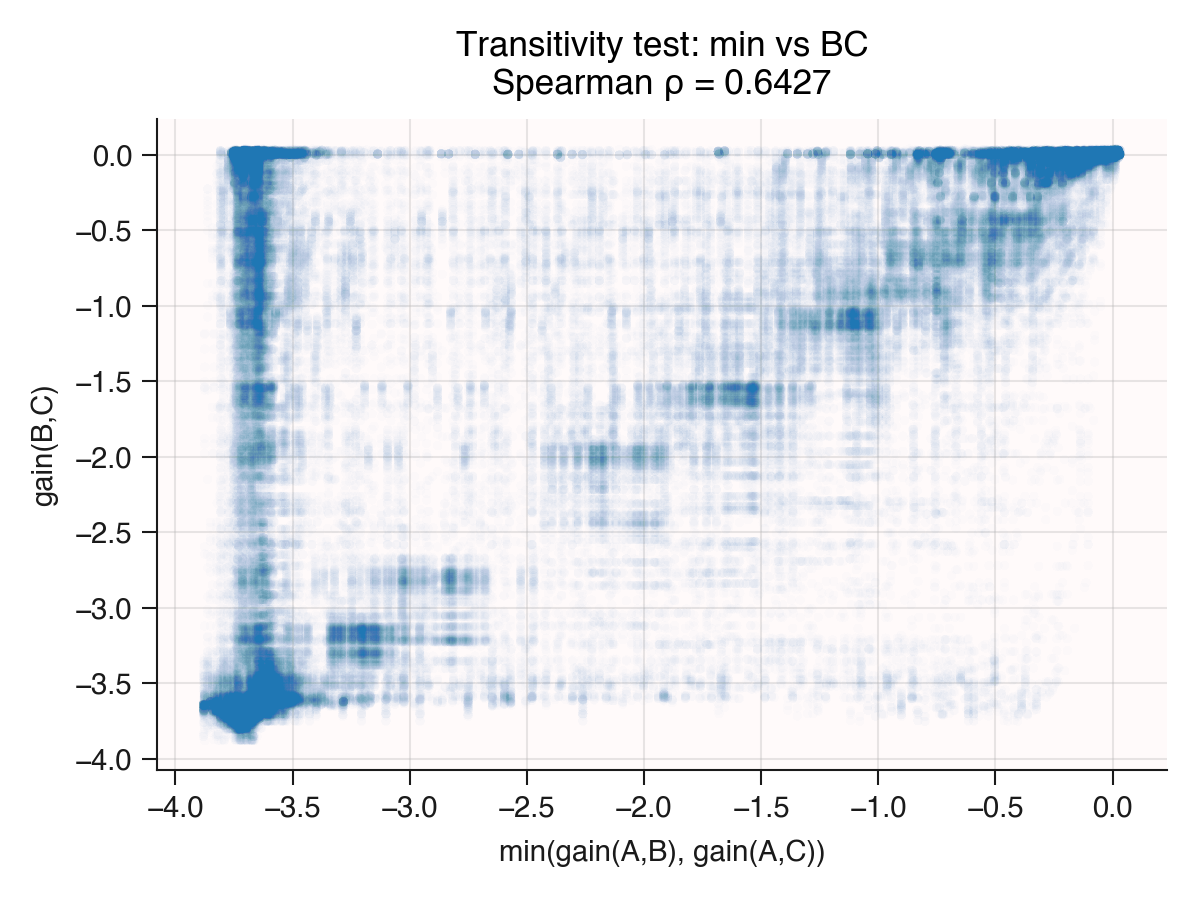

In [151]:
rho_min, _ = spearmanr(tri_df['min_ab_ac'], tri_df['bc'])

fig, ax = plt.subplots()
ax.scatter(
    tri_df['min_ab_ac'],
    tri_df['bc'],
    s=4,
    alpha=0.01,
    edgecolors='none',
    antialiased=False
)

ax.set_xlabel('min(gain(A,B), gain(A,C))')
ax.set_ylabel('gain(B,C)')
ax.set_title(f'Transitivity test: min vs BC\nSpearman ρ = {rho_min:.4f}')
ax.grid(True, which='major', alpha=0.3)

plt.tight_layout()
plt.show()

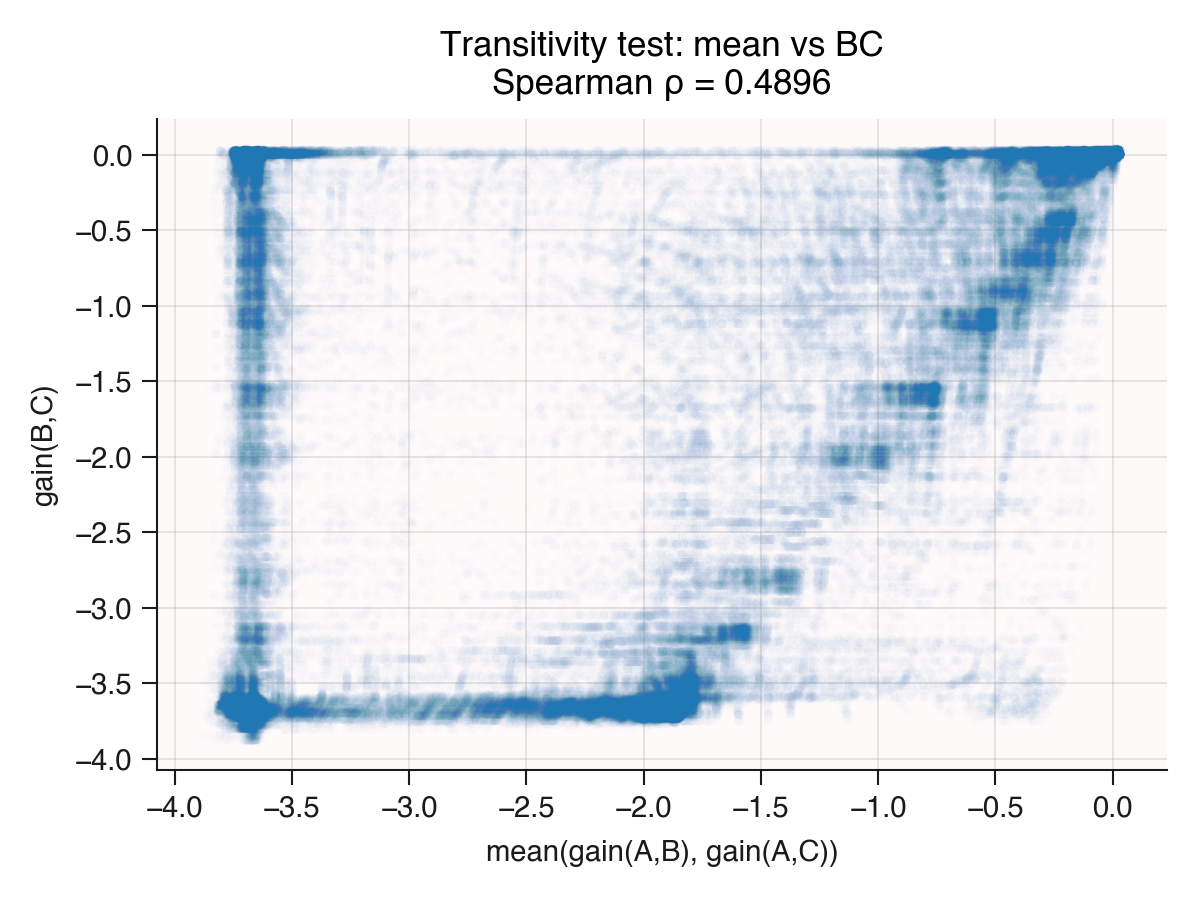

In [153]:
rho_mean, _ = spearmanr(tri_df['mean_ab_ac'], tri_df['bc'])

fig, ax = plt.subplots()
ax.scatter(
    tri_df['mean_ab_ac'],
    tri_df['bc'],
    s=4,
    alpha=0.01,
    edgecolors='none',
    antialiased=False
)

ax.set_xlabel('mean(gain(A,B), gain(A,C))')
ax.set_ylabel('gain(B,C)')
ax.set_title(f'Transitivity test: mean vs BC\nSpearman ρ = {rho_mean:.4f}')
ax.grid(True, which='major', alpha=0.3)

plt.tight_layout()
plt.show()

In [129]:
from scipy.stats import spearmanr, pearsonr

spearman_min = spearmanr(tri_df['min_ab_ac'], tri_df['bc'])
pearson_min = pearsonr(tri_df['min_ab_ac'], tri_df['bc'])

spearman_mean = spearmanr(tri_df['mean_ab_ac'], tri_df['bc'])
pearson_mean = pearsonr(tri_df['mean_ab_ac'], tri_df['bc'])

spearman_min, pearson_min, spearman_mean, pearson_mean


(SignificanceResult(statistic=np.float64(0.6426737719667915), pvalue=np.float64(0.0)),
 PearsonRResult(statistic=np.float64(0.6541861003288454), pvalue=np.float64(0.0)),
 SignificanceResult(statistic=np.float64(0.4895949509388966), pvalue=np.float64(0.0)),
 PearsonRResult(statistic=np.float64(0.4275007909389672), pvalue=np.float64(0.0)))

## Binary Labels of gain > 0

In [130]:
soups = soups.copy()

# Binary label: 1 if souping helps (gain > 0), else 0
soups['gain_pos'] = (soups['soup_gain'] > 0).astype(int)

# Unordered edge representation
soups['u'] = soups[['key_a', 'key_b']].min(axis=1)
soups['v'] = soups[['key_a', 'key_b']].max(axis=1)

# Lookup: (model_i, model_j) -> gain_pos
gain_lookup = (
    soups
    .set_index(['u', 'v'])['gain_pos']
    .to_dict()
)


In [131]:
import itertools
import numpy as np

# Use all models that appear in soups
keys = pd.Index(soups['u']).append(pd.Index(soups['v'])).unique()

triangles = list(itertools.combinations(keys, 3))

rows = []

for A, B, C in triangles:
    ab = gain_lookup.get(tuple(sorted((A, B))))
    ac = gain_lookup.get(tuple(sorted((A, C))))
    bc = gain_lookup.get(tuple(sorted((B, C))))

    # Only keep triangles where all three soups exist
    if ab is None or ac is None or bc is None:
        continue

    n_pos_abac = ab + ac  # number of positive edges touching A (0,1,2)

    rows.append({
        'ab_pos': ab,
        'ac_pos': ac,
        'bc_pos': bc,
        'n_pos_abac': n_pos_abac,
        'mean_abac_pos': 0.5 * (ab + ac)
    })

tri_bin_df = pd.DataFrame(rows)


In [132]:
# Group by how many of (A,B) and (A,C) are positive
prob_bc_given_abac = (
    tri_bin_df
    .groupby('n_pos_abac')['bc_pos']
    .mean()
    .reset_index()
    .rename(columns={'bc_pos': 'p_bc_pos'})
)

prob_bc_given_abac


,n_pos_abac,p_bc_pos
0,0,0.182523
1,1,0.082534
2,2,0.916578


In [133]:
count_df = (
    tri_bin_df
    .groupby('n_pos_abac')
    .size()
    .reset_index(name='n_triangles')
)

plot_df = prob_bc_given_abac.merge(count_df, on='n_pos_abac')
plot_df


,n_pos_abac,p_bc_pos,n_triangles
0,0,0.182523,149784
1,1,0.082534,23869
2,2,0.916578,8451


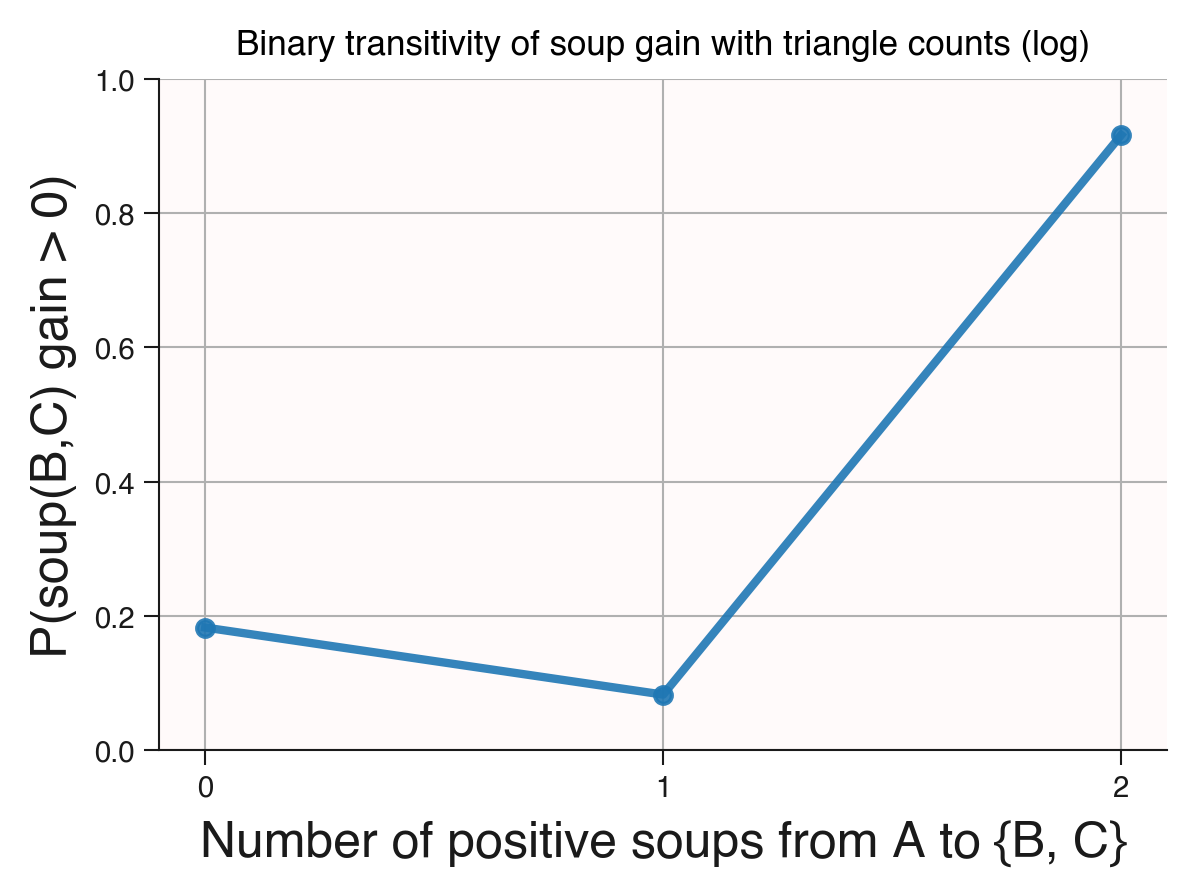

In [134]:
fig, ax1 = plt.subplots()
# Axis 1: probability
ax1.plot(
    plot_df['n_pos_abac'],
    plot_df['p_bc_pos'],
    marker='o',
    markersize=4,
    linewidth=2,
    alpha=0.9
)
ax1.set_xlabel('Number of positive soups from A to {B, C}', fontsize=12)
ax1.set_ylabel('P(soup(B,C) gain > 0)', fontsize=12)
ax1.set_ylim(0, 1)

# Axis 2: counts (log scale)
# ax2 = ax1.twinx()
# ax2.plot(
#     plot_df['n_pos_abac'],
#     # plot_df['n_triangles'],
#     marker='o',
#     markersize=4,
#     linewidth=2,
#     linestyle='--',
# )
# ax2.set_ylabel('Number of triangles (log scale)')
# ax2.set_yscale('log')

ax1.set_xticks([0, 1, 2])
ax1.set_title('Binary transitivity of soup gain with triangle counts (log)')

plt.tight_layout()
plt.show()

## Clustering!

In [135]:
import numpy as np

keys = models_df['key'].unique()
key_to_idx = {k: i for i, k in enumerate(keys)}
n = len(keys)

# Initialise with NaNs
gain_mat = np.full((n, n), np.nan)

for _, r in soups.iterrows():
    i = key_to_idx[r['key_a']]
    j = key_to_idx[r['key_b']]
    gain_mat[i, j] = r['soup_gain']
    gain_mat[j, i] = r['soup_gain']

# Self entries: define soup_gain(A,A) = 0
np.fill_diagonal(gain_mat, 0.0)

In [136]:
# Binary part: 0 for positive soup gain, 1 otherwise
gain_pos = (gain_mat > 0).astype(float)
d_bin = 1.0 - gain_pos   # 0 if gain > 0, 1 if gain <= 0

# Magnitude part: only care about negative gains, clip extremes
neg_gain = np.where(gain_mat < 0, -gain_mat, 0.0)

# Clip at 90th percentile to avoid huge negatives dominating
neg_vals = neg_gain[neg_gain > 0]
if neg_vals.size > 0:
    tau = np.percentile(neg_vals, 90)
    neg_gain = np.minimum(neg_gain, tau)
    d_mag = neg_gain / tau
else:
    d_mag = np.zeros_like(neg_gain)

# Combine: binary dominates, magnitude is a refinement
w_bin = 1.0
w_mag = 0.1  # adjust if you want magnitude to matter more/less

D = w_bin * d_bin + w_mag * d_mag

# Distance of a point to itself must be 0
np.fill_diagonal(D, 0.0)

In [137]:
from sklearn.manifold import MDS

mds = MDS(
    n_components=2,
    dissimilarity='precomputed',
    random_state=0,
    normalized_stress='auto'
)

X = mds.fit_transform(D)

/Users/pierrelardet/too-salty/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [138]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 55  # tune after inspection

clust = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='average'
)

labels = clust.fit_predict(D)

In [139]:
plot_df = pd.DataFrame({
    'x': X[:, 0],
    'y': X[:, 1],
    'key': keys,
    'cluster': labels,
})

plot_df = plot_df.merge(
    models_df[['key', 'epoch', 'variant']],
    on='key',
    how='left'
)

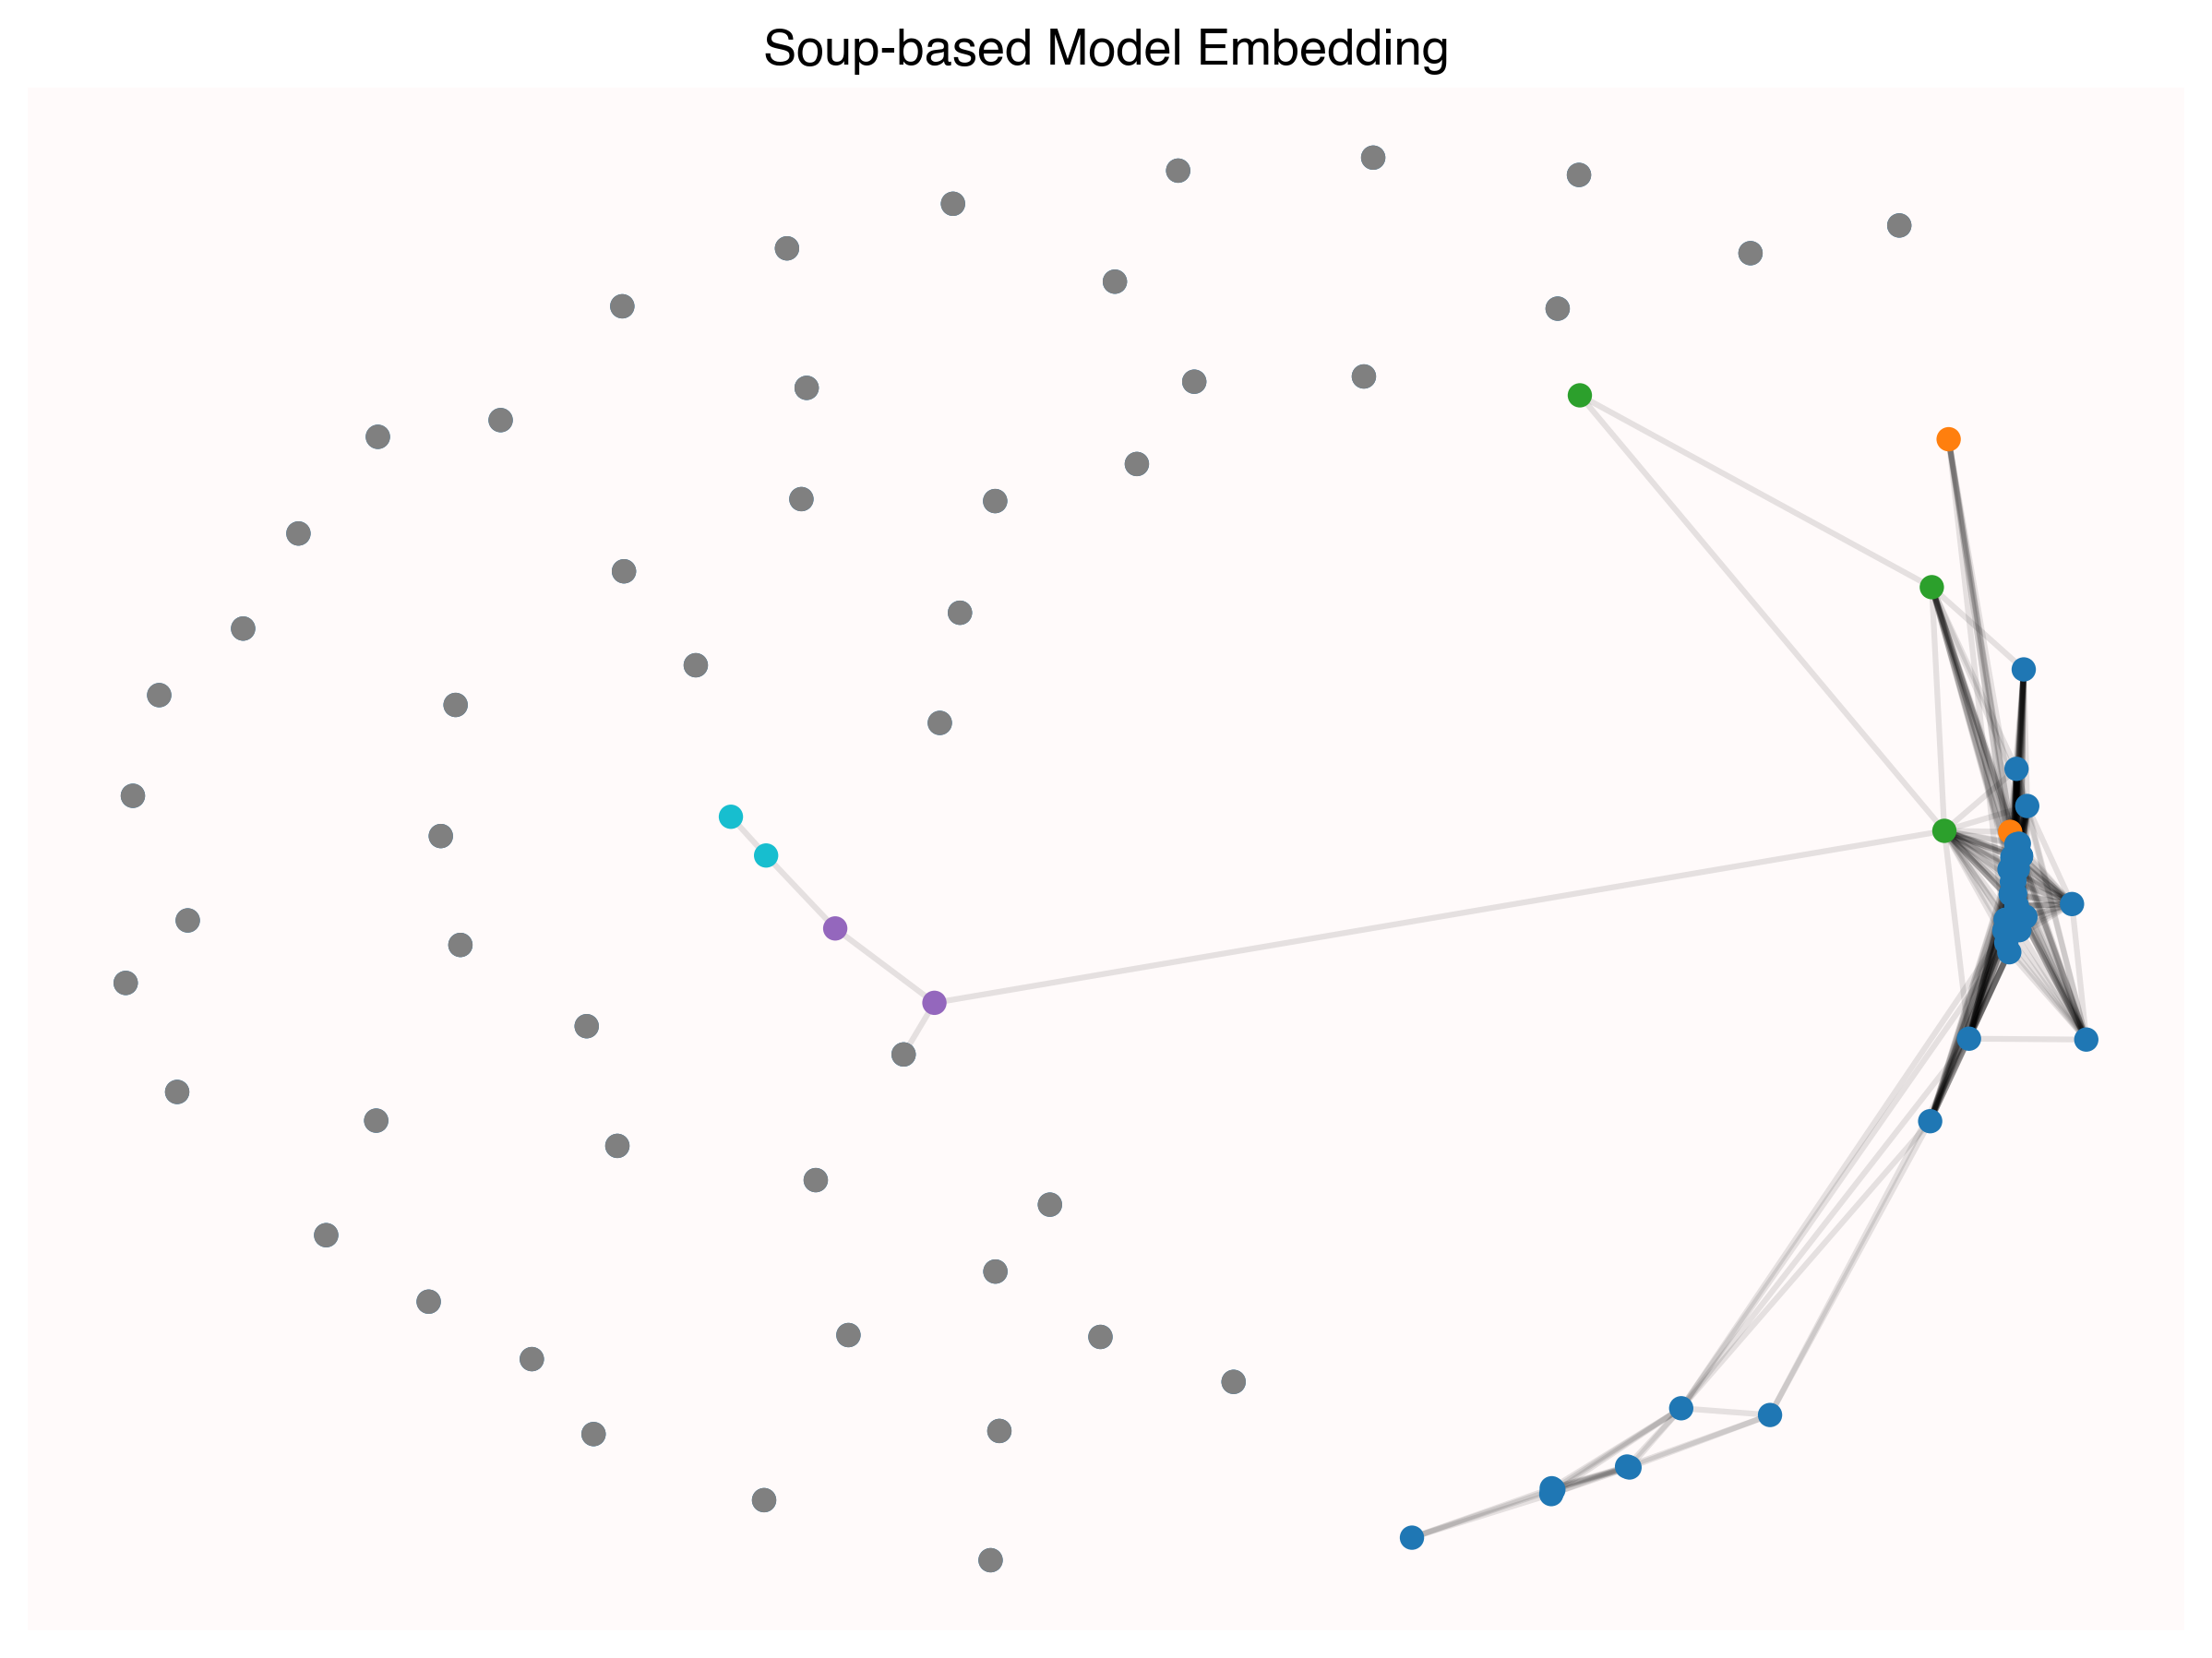

In [154]:
# Identify singleton clusters
cluster_sizes = plot_df['cluster'].value_counts()
singleton_clusters = cluster_sizes[cluster_sizes == 1].index

# Build color array: grey for singletons, cluster id for others
colors = plot_df['cluster'].copy()
colors = colors.where(~plot_df['cluster'].isin(singleton_clusters), other=-1)

fig, ax = plt.subplots(figsize=(8, 6))

good_edges = soups[soups['soup_gain'] > 0]
n_draw = len(good_edges)
if n_draw > 0:
    for _, r in good_edges.sample(n_draw, random_state=0).iterrows():
        i = key_to_idx[r['key_a']]
        j = key_to_idx[r['key_b']]
        ax.plot(
            [X[i, 0], X[j, 0]],
            [X[i, 1], X[j, 1]],
            color='black',
            alpha=0.1,
            zorder=0
        )

sc = ax.scatter(
    plot_df['x'],
    plot_df['y'],
    c=colors,
    cmap='tab10',   # normal clusters
    s=40,
    alpha=1.0,
    zorder=1,
    # Remove edges
    edgecolors='none'
)

# Manually recolor singletons to grey
mask_singletons = plot_df['cluster'].isin(singleton_clusters)
ax.scatter(
    plot_df.loc[mask_singletons, 'x'],
    plot_df.loc[mask_singletons, 'y'],
    c='grey',
    s=40,
    alpha=1.0,
    label='Singletons',
    edgecolors='none',
    zorder=2
)

ax.set_title('Soup-based Model Embedding', fontsize=13)
# ax.set_xlabel('MDS-1', fontsize=12)
# ax.set_ylabel('MDS-2', fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_facecolor((1, 0.98, 0.98))
# ax.legend(handles=sc.legend_elements()[0], labels=[str(i) for i in range(n_clusters)] + ['Singletons'], title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.grid(True, which='major', alpha=0.3)
# ax.minorticks_on()
# ax.grid(True, which='minor', alpha=0.15)

plt.tight_layout()
plt.show()

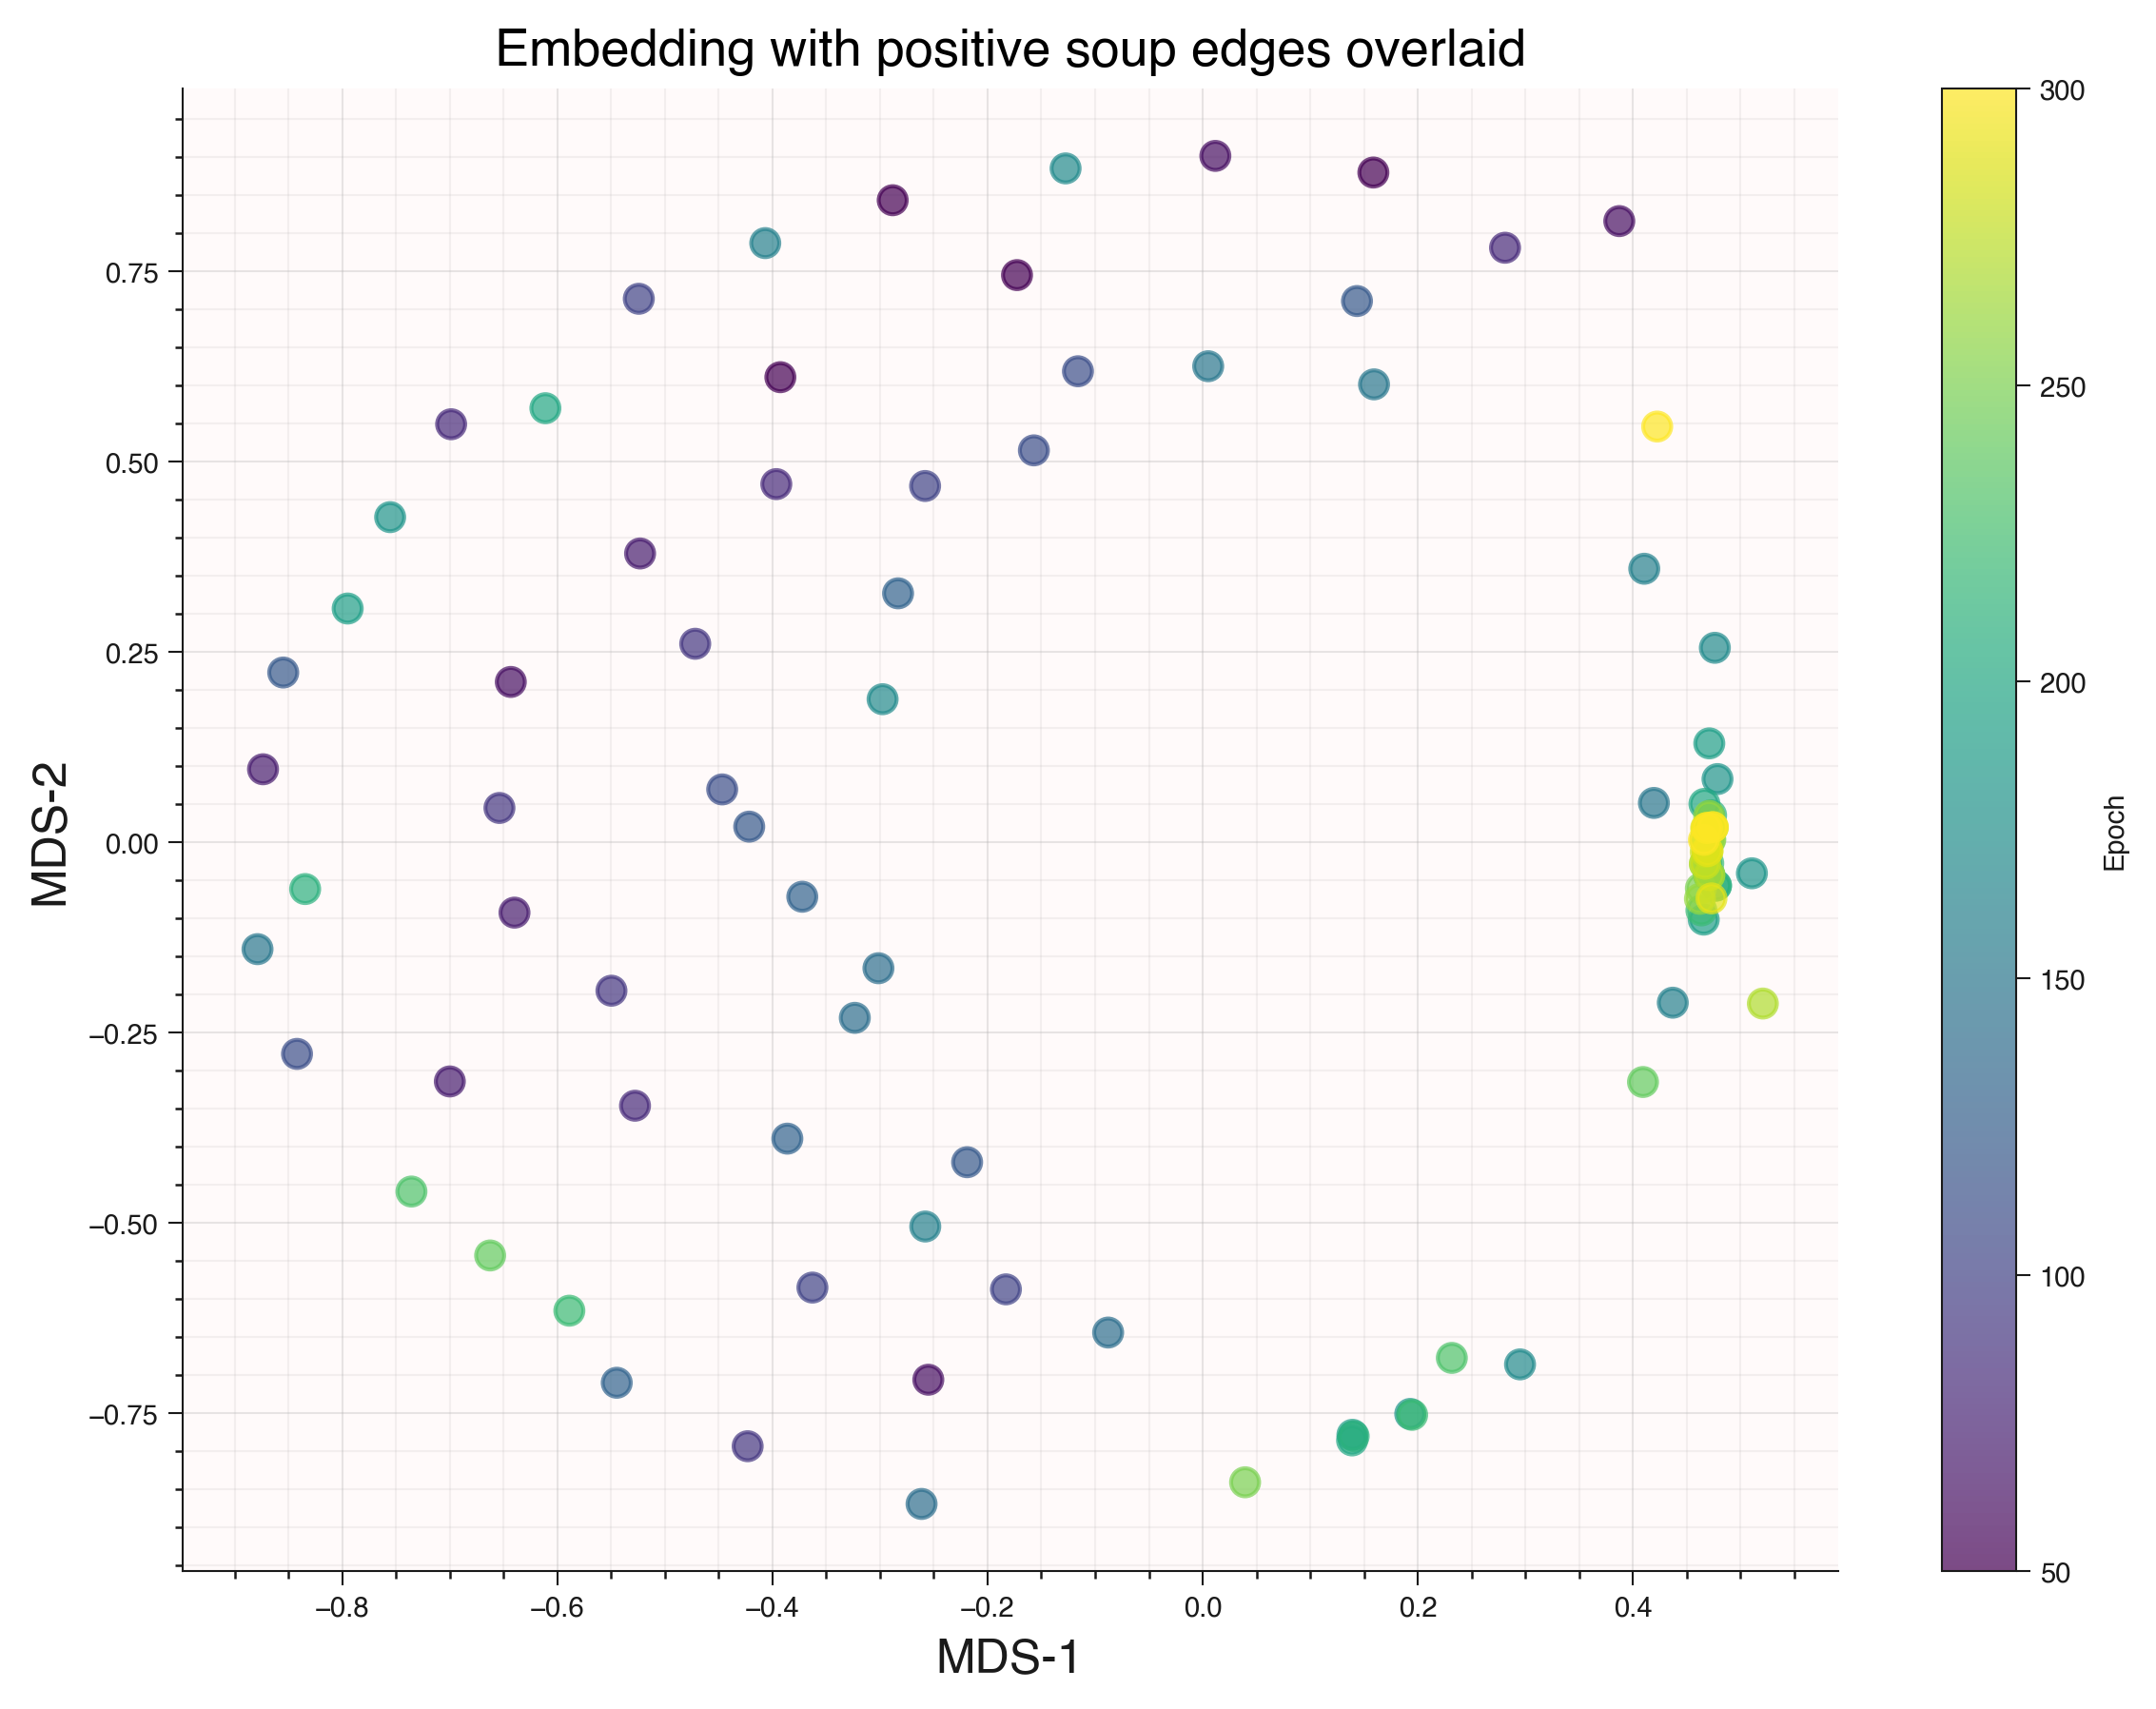

In [141]:

fig, ax = plt.subplots(figsize=(8, 6))

# Nodes coloured by agglomerative cluster
sc = ax.scatter(
    plot_df['x'],
    plot_df['y'],
    # c=plot_df['cluster'],
    c=plot_df['epoch'],
    s=50,
    alpha=0.7
)

cb = plt.colorbar(sc, ax=ax)
cb.set_label('Epoch')

ax.set_title('Embedding with positive soup edges overlaid', fontsize=13)
ax.set_xlabel('MDS-1', fontsize=12)
ax.set_ylabel('MDS-2', fontsize=12)

ax.grid(True, which='major', alpha=0.3)
ax.minorticks_on()
ax.grid(True, which='minor', alpha=0.15)

plt.tight_layout()
plt.show()

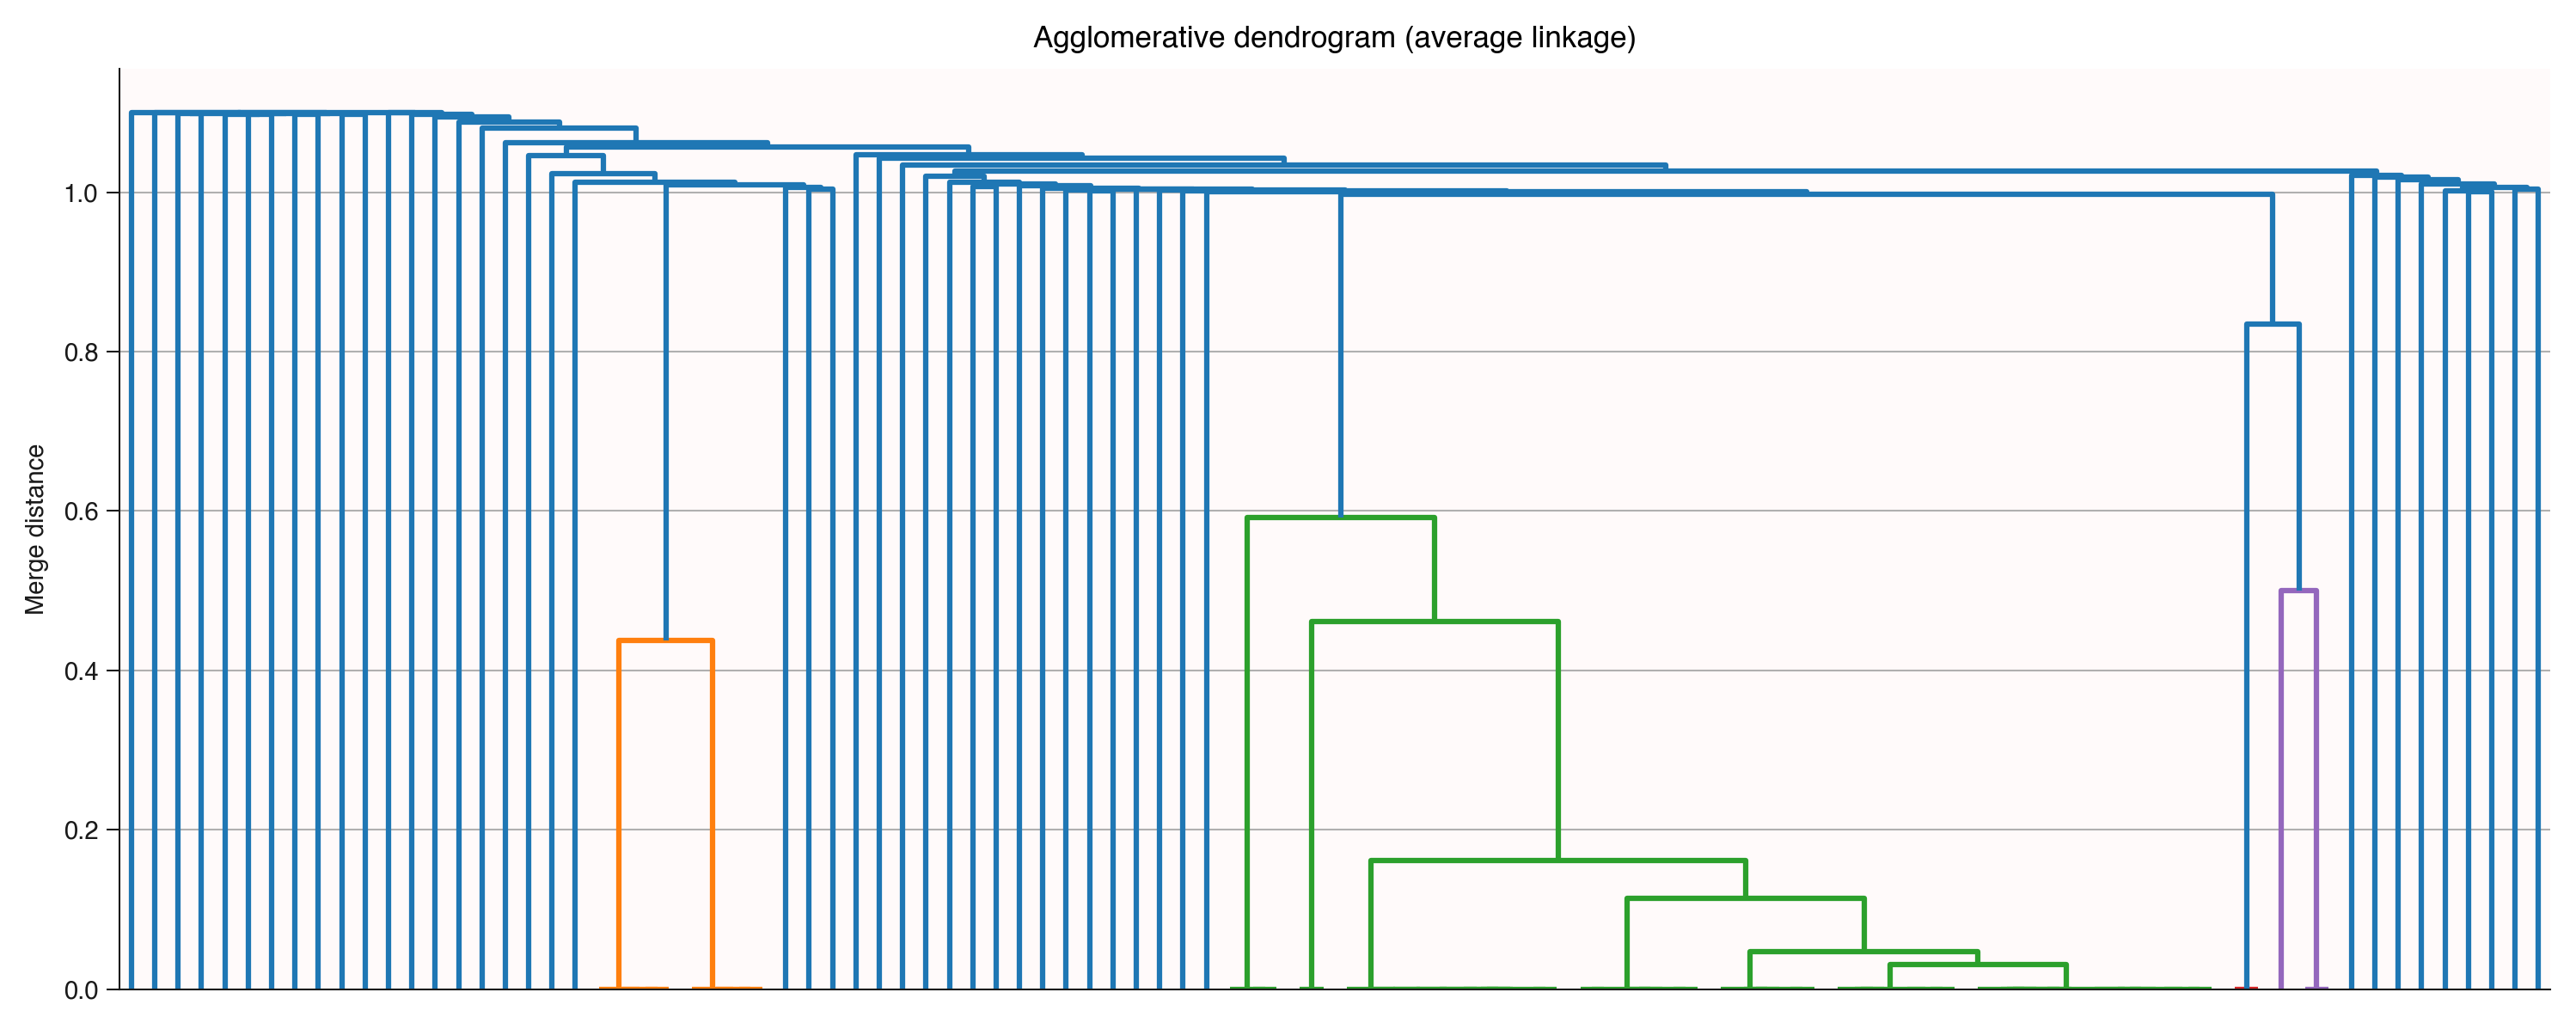

In [142]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

Z = linkage(squareform(D), method='average')

fig, ax = plt.subplots(figsize=(10, 4))
dendrogram(Z, no_labels=True, ax=ax)
ax.set_title('Agglomerative dendrogram (average linkage)')
ax.set_ylabel('Merge distance')
plt.tight_layout()
plt.show()


In [143]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    metric='precomputed',
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=0
)

X_tsne = tsne.fit_transform(D)

plot_df['tsne_x'] = X_tsne[:, 0]
plot_df['tsne_y'] = X_tsne[:, 1]


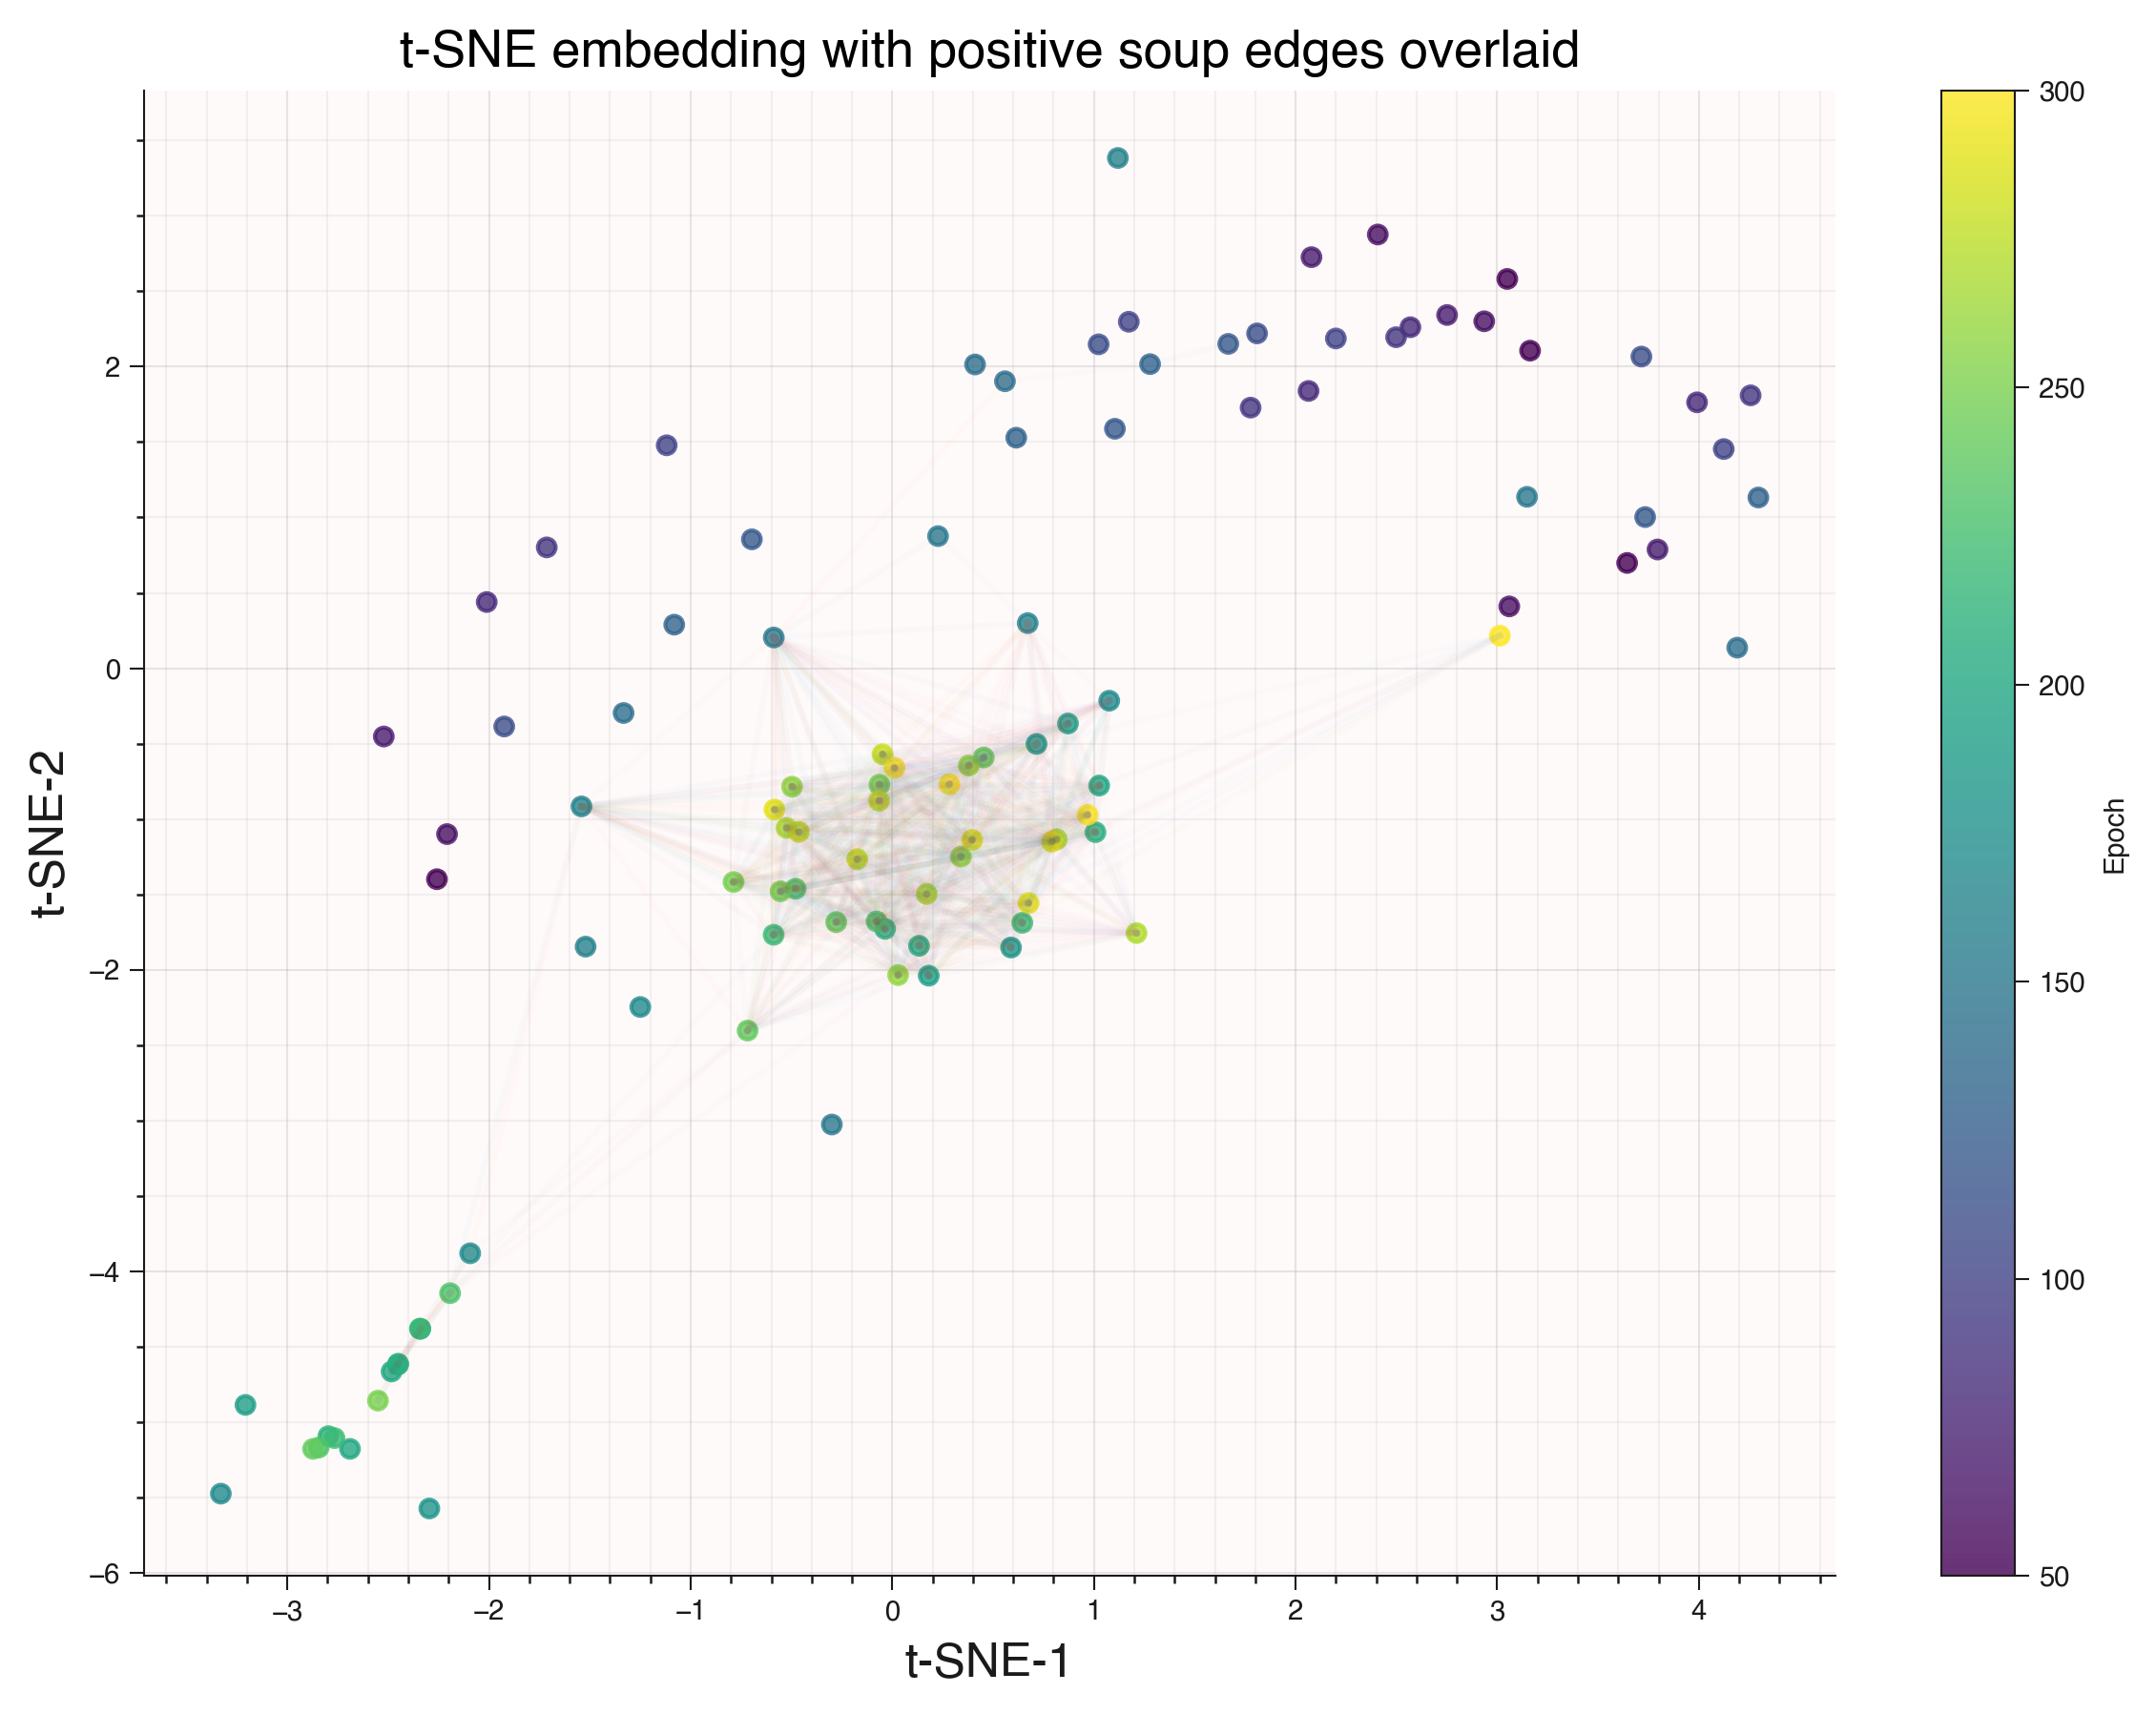

In [144]:
fig, ax = plt.subplots(figsize=(8, 6))

# Nodes
sc = ax.scatter(
    plot_df['tsne_x'],
    plot_df['tsne_y'],
    c=plot_df['epoch'],
    s=20,
    alpha=0.8
)

cb = plt.colorbar(sc, ax=ax)
cb.set_label('Epoch')

# Overlay positive soup edges
n_draw = len(good_edges)
if n_draw > 0:
    for _, r in good_edges.sample(n_draw, random_state=0).iterrows():
        i = key_to_idx[r['key_a']]
        j = key_to_idx[r['key_b']]
        ax.plot(
            [plot_df.loc[i, 'tsne_x'], plot_df.loc[j, 'tsne_x']],
            [plot_df.loc[i, 'tsne_y'], plot_df.loc[j, 'tsne_y']],
            alpha=0.02
        )

ax.set_title('t-SNE embedding with positive soup edges overlaid', fontsize=13)
ax.set_xlabel('t-SNE-1', fontsize=12)
ax.set_ylabel('t-SNE-2', fontsize=12)

ax.grid(True, which='major', alpha=0.3)
ax.minorticks_on()
ax.grid(True, which='minor', alpha=0.15)

plt.tight_layout()
plt.show()